# Phân tích điểm thi THPT bằng phương pháp thống kê và hồi quy tuyến tính


## 1. Giới thiệu

Trong đề tài này, chúng ta thực hiện phân tích tập dữ liệu điểm thi THPT 2024 của hơn 1 triệu thí sinh. Mục tiêu bao gồm:

- Phân tích thống kê mô tả điểm thi theo từng môn và theo tỉnh.

- So sánh điểm giữa nhóm học sinh giỏi Toán và không.

- Trực quan hóa tương quan giữa các môn.

- Xây dựng mô hình hồi quy tuyến tính dự đoán điểm Lý từ các môn khác.


## 2. Đọc dữ liệu và tiền xử lý


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Đọc dữ liệu
df = pd.read_csv("datasets/diem_thi_thpt_2024.csv")

# Đổi tên cột cho dễ đọc
df.columns = ['sbd', 'toan', 'van', 'nn', 'ly', 'hoa', 'sinh', 'su', 'dia', 'gdcd', 'ma_nn']

# Chuyển kiểu dữ liệu các cột điểm thành dạng float
cols = ['toan', 'van', 'nn', 'ly', 'hoa', 'sinh', 'su', 'dia', 'gdcd']
df[cols] = df[cols].apply(pd.to_numeric, errors = 'coerce')

# Loại bỏ dòng không có điểm Toán 
df = df[df['toan'].notna()]

## 3. Thêm cột tỉnh từ mã số báo danh


In [13]:
# Mã tỉnh (2 chữ số đầu của SBD)
ma_tinh = {
    '01': 'Hà Nội', '02': 'TP. Hồ Chí Minh', '03': 'Hải Phòng', '04': 'Đà Nẵng',
    '05': 'Hà Giang', '06': 'Cao Bằng', '07': 'Lai Châu', '08': 'Lào Cai',
    '09': 'Tuyên Quang', '10': 'Lạng Sơn', '11': 'Bắc Kạn', '12': 'Thái Nguyên',
    '13': 'Yên Bái', '14': 'Sơn La', '15': 'Phú Thọ', '16': 'Vĩnh Phúc',
    '17': 'Quảng Ninh', '18': 'Bắc Giang', '19': 'Bắc Ninh', '21': 'Hải Dương',
    '22': 'Hưng Yên', '23': 'Hòa Bình', '24': 'Hà Nam', '25': 'Nam Định',
    '26': 'Thái Bình', '27': 'Ninh Bình', '28': 'Thanh Hóa', '29': 'Nghệ An',
    '30': 'Hà Tĩnh', '31': 'Quảng Bình', '32': 'Quảng Trị', '33': 'Thừa Thiên-Huế',
    '34': 'Quảng Nam', '35': 'Quảng Ngãi', '36': 'Kon Tum', '37': 'Bình Định',
    '38': 'Gia Lai', '39': 'Phú Yên', '40': 'Đắk Lắk', '41': 'Khánh Hòa',
    '42': 'Lâm Đồng', '43': 'Bình Phước', '44': 'Bình Dương', '45': 'Ninh Thuận',
    '46': 'Tây Ninh', '47': 'Bình Thuận', '48': 'Đồng Nai', '49': 'Long An',
    '50': 'Đồng Tháp', '51': 'An Giang', '52': 'Bà Rịa-Vũng Tàu', '53': 'Tiền Giang',
    '54': 'Kiên Giang', '55': 'Cần Thơ', '56': 'Bến Tre', '57': 'Vĩnh Long',
    '58': 'Trà Vinh', '59': 'Sóc Trăng', '60': 'Bạc Liêu', '61': 'Cà Mau',
    '62': 'Điện Biên', '63': 'Đắk Nông', '64': 'Hậu Giang'
}

df['ma_tinh'] = df['sbd'].astype(str).str[:2]
df['tinh'] = df['ma_tinh'].map(ma_tinh)

## 4. Phân tích thống kê mô tả điểm số theo tỉnh


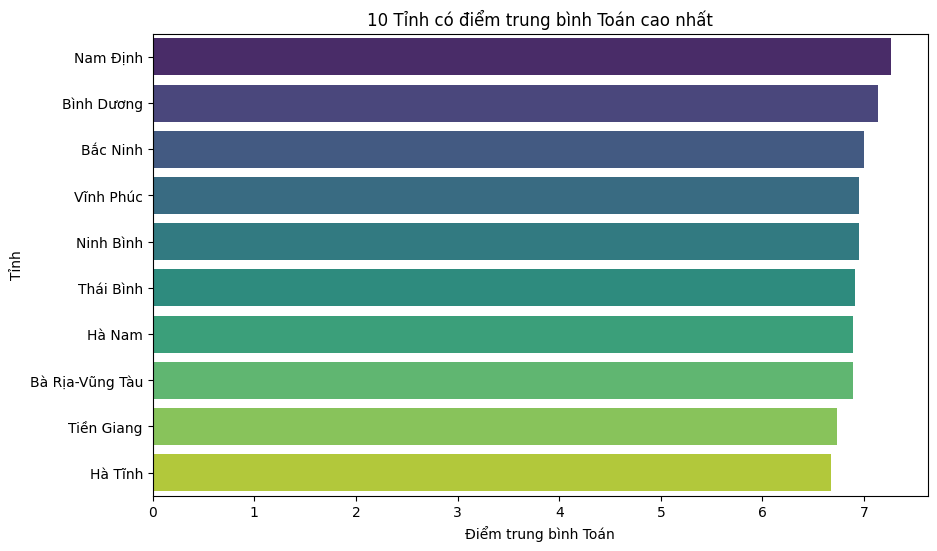

In [14]:
# Trung bình điểm Toán theo tỉnh
diem_tb_tinh = df.groupby('tinh')['toan'].mean().sort_values(ascending = False).head(10) # Có thể lấy số khác ngoài 10

plt.figure(figsize = (10,6))
sns.barplot(x = diem_tb_tinh.values, y = diem_tb_tinh.index, palette = 'viridis')
plt.title("10 Tỉnh có điểm trung bình Toán cao nhất")
plt.xlabel("Điểm trung bình Toán")
plt.ylabel("Tỉnh")
plt.show()

## 5. So sánh nhóm học sinh giỏi Toán


Trung bình môn Hóa theo nhóm 'giỏi Toán':
gioi_toan
False    6.204636
True     7.351157
Name: hoa, dtype: float64


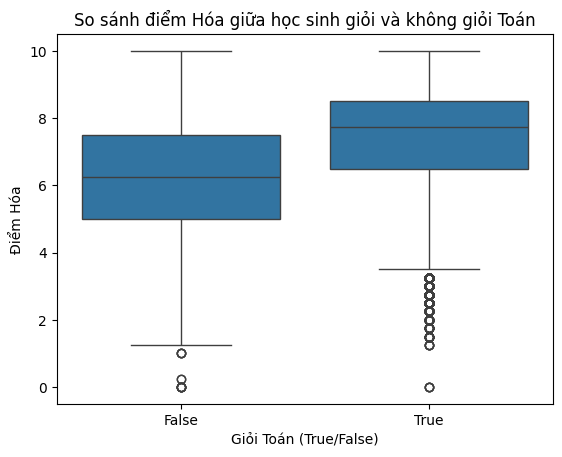

In [ ]:
df['gioi_toan'] = df['toan'] >= 8.0 # Giỏi Toán nếu điểm >= 8.0

print("Trung bình môn Hóa theo nhóm 'giỏi Toán':")
print(df.groupby('gioi_toan')['hoa'].mean())

sns.boxplot(data=df, x='gioi_toan', y='hoa')
plt.title("So sánh điểm Hóa giữa học sinh giỏi và không giỏi Toán")
plt.xlabel("Giỏi Toán (True/False)")
plt.ylabel("Điểm Hóa")
plt.show()

## 6. Trực quan hóa tương quan giữa các môn (sử dụng heatmap)


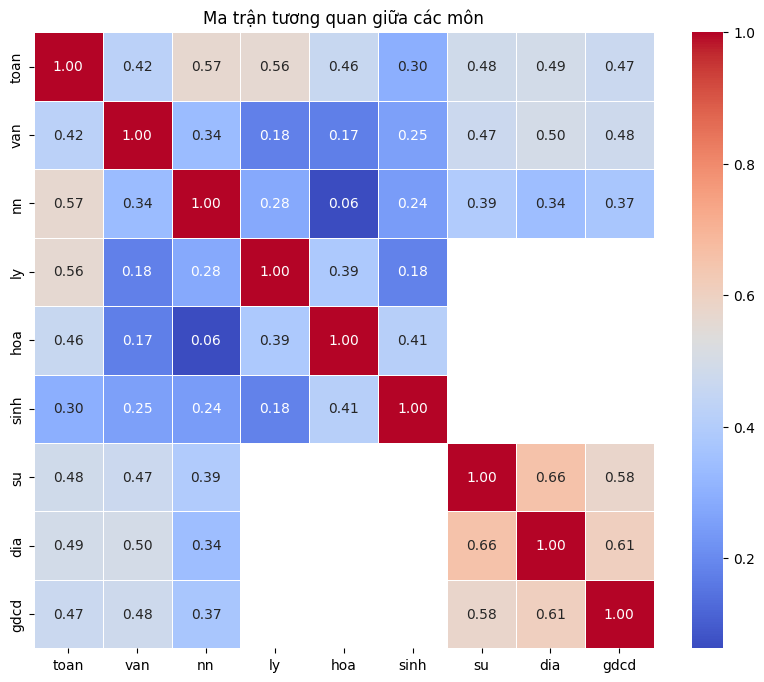

In [19]:
plt.figure(figsize = (10, 8))
corr = df[cols].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title("Ma trận tương quan giữa các môn")
plt.show()

### Giải thích:

- Giá trị gần 1: tương quan thuận mạnh
- Gần 0: không tương quan

Ta có thể thấy Lý có tương quan mạnh với toán (0.56) và hóa (0.39) nên có thể dùng hồi quy để dự đoán. (Chọn 2 môn có tương quan cao với môn cần dự đoán, có thể chọn dự đoán toán dựa trên lý với anh cũng được)


## 7. Hồi quy tuyến tính: Dự đoán điểm Toán từ Lý và Anh


In [ ]:
df_model = df[['toan', 'ly', 'nn']].dropna() # Chọn các cột Toán, Lý, Anh để xây dựng mô hình hồi quy tuyến tính

X = df_model[['ly', 'nn']]
y = df_model['toan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("Hồi quy tuyến tính: Dự đoán điểm Toán từ Lý và Ngoại ngữ")
print("Hệ số hồi quy:", model.coef_)
print("Intercept:", model.intercept_)
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

Hồi quy tuyến tính: Dự đoán điểm Toán từ Lý và Ngoại ngữ
Hệ số hồi quy: [0.28430669 0.12046537]
Intercept: 4.9185885514989955
R²: 0.3687
RMSE: 0.7379


## 8. Diễn giải mô hình hồi quy

Kết quả sau khi train là:

```
Hồi quy tuyến tính: Dự đoán điểm Toán từ Lý và Ngoại ngữ
Hệ số hồi quy: [0.28430669 0.12046537]
Intercept: 4.9185885514989955
R²: 0.3687
RMSE: 0.7379
```

Từ kết quả trên ta có thể đưa ra kết luận:

- Phương trình hồi quy:
     - Điểm Toán = 0.284 x Lý + 0.120 x Ngoại ngữ + 4.919
- Hệ số hồi quy cho thấy:
     - Điểm Lý có ảnh hưởng lớn hơn đến điểm Toán (hệ số 0.284), cho thấy mối quan hệ giữa hai môn trong khối tự nhiên.
     - Điểm Ngoại ngữ có ảnh hưởng yếu hơn (hệ số 0.120), nhưng vẫn đóng góp nhất định vào mô hình dự đoán.
- R² = 0.3687:
     - Ý nghĩa: Khoảng 36.87% phương sai của điểm Toán được giải thích bởi hai biến đầu vào là Lý và Ngoại ngữ.
     - Đây là một mức độ giải thích trung bình, mô hình có khả năng dự đoán khá nhưng không quá mạnh.
- RMSE = 0.7379:
     - Sai số trung bình trong dự đoán là 0.74 điểm, tức là mô hình dự đoán điểm Toán tương đối gần với thực tế.

## 9. Đánh giá

- Mô hình cho thấy điểm Toán có liên hệ tương đối với điểm Lý và một phần nhỏ từ điểm Ngoại ngữ. (Cần thêm đánh giá khi đưa vào báo cáo.)
